## Abstract

In this document I will calculate the importance of each feature in a complex model (XGBoost) using **Permutation Feature Importance**. For more information about **Permutation Feature Importance**, go and read the great book [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/permutation-feature-importance.html).

I tried to use the [ELI5]() python package, but it has been impossible. So I did it myself (it is very easy).

## Load the model, the data and the needed packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
import warnings
import pdb

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 6)
warnings.filterwarnings(action = "once")

Populating the interactive namespace from numpy and matplotlib


In [3]:
model, training_set, test_set = joblib.load("../../0-model-to-explain/model_and_data_python.sav")

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Calculate feature importance

There are several ways of calculating feature importance. We will use **Permutation Feature Importance**, which has the advantage of being a generic algorithm that can be used in any black box model, and compare the results with other tree-specific methods.

In [4]:
def score(x, y):
    prediction = model.predict(x)
    reference = y.values
    right = np.sum(np.equal(prediction, reference))
    acc = right / len(reference)
    return acc

We first need a reference accuracy:

In [5]:
X_test = test_set.drop(columns="Survived")
acc_ref = score(x = X_test, y = test_set.Survived)
print("Reference accuracy: {}".format(acc_ref))

Reference accuracy: 0.7803030303030303


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Now we need a function to permute a dataframe column. Let's create it!

In [6]:
def permute_column(df, column_index):
    return np.random.permutation(df.iloc[:,column_index])

Now let's build a function that calculates the importance of a particular feature:

In [7]:
def feature_importance(test_data, test_labels, 
                       column_index, model, 
                       acc_ref, n_permutations = 2):
    
    importances = np.zeros(shape = (n_permutations))
   # pdb.set_trace()
    for i in range(n_permutations):
        test_data.iloc[:, column_index] = permute_column(test_data, column_index)
        acc = score(test_data, test_labels)
        importances[i] = acc_ref - acc
        
    return importances
    

Nice! Let's now calculate the importance of all our no-one-hot-encoded features:

In [8]:
N_PERM = 500

In [9]:
X_test.columns

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [10]:
permutation_feature_importance = list()
feature_list = [0,1,2,3,4]

for i in feature_list:
    permutation_feature_importance.append(
        feature_importance(
            test_data = X_test,
            test_labels = test_set.Survived, 
            column_index = i,
            model = model,
            acc_ref = acc_ref,
            n_permutations = N_PERM
        )
    )

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


And now we can plot the results:

In [11]:
feature_names = [X_test.columns[i] for i in feature_list]
x_plot = [value for l in permutation_feature_importance for value in l]
y_plot = [f_name for f_name in feature_names for i in range(N_PERM)]

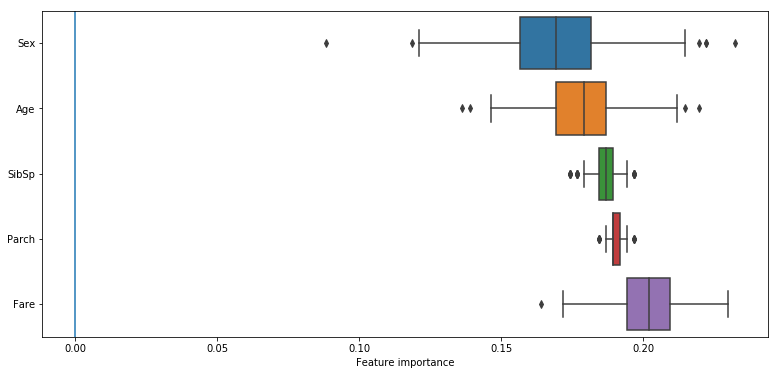

In [12]:
sns.boxplot(x = x_plot, y = y_plot);
plt.axvline(x = 0);
plt.xlabel("Feature importance");

Mmmmm, hay algo mal aquí... REVISA